#### Amy Schneider & Alonna Guerrero ####

# Acute Lymphoblastic Leukemia Blood Smear Image Analysis
## Introduction
The C-NMC dataset is data from the IEEE International Symposium on Biomedical Imaging and was originally part of a challenge at the conference and was found on Kaggle [here.](https://www.kaggle.com/code/behcetsenturk/leukemia-classification-from-cell-images) The data provides images of blood cells, some of which are positive for Acute Lymphoblastic Leukemia, or ALL, as well as normal blood cells. The challenge details specifically note that distinguishing ALL cells from normal cells is difficult as "cell types appear similar under the microscope and subject-level variability plays a key role." The training data has been reviewed by an expert and ALL cells are placed in files with the suffix "all," while normal cells are in files with the "hem" suffix (in pathology, "hem" means blood), which serve as the ground truth labels.

Our aim with this dataset is to build a model that can distinguish between healthy and ALL cells with maximum accuracy and precision.  Image recognition problems such as this can aid pathologists and oncologists in screening samples, but also in decision-making, and help provide quicker and more accurate diagnoses in order to allow those diagnosed with ALL quicker access to potentially lifesaving treatment.

We start by loading necessary packages for analysis, utilizing Google Drive storage for the image files and connection to them from this notebook.

In [9]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import cv2
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

## Data Exploration and Loading
Our next task is to navigate the folders within the zipped file to pull all the relevant images into a combined and manageable dataset for analysis.

In [ ]:
import zipfile
import os

## Ensure that you have the .zip file in the same folder that you run this notebook in

# Specify the path to the uploaded zip file
zip_file_path = 'C-NMC_Leukemia.zip'

# Specify the directory where you want to extract the contents
extract_dir = 'extracted_contents'

# Create a directory to extract the contents into
os.makedirs(extract_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files and directories
extracted_files = os.listdir(extract_dir)
print("Extracted files and directories:", extracted_files)

# Directory containing the extracted files
extracted_dir = os.path.join(extract_dir, 'C-NMC_Leukemia')

# List the contents of the C-NMC_Leukemia directory
leukemia_contents = os.listdir(extracted_dir)
print("Contents of C-NMC_Leukemia directory:", leukemia_contents)

Extracted files and directories: ['__MACOSX', 'C-NMC_Leukemia']
Contents of C-NMC_Leukemia directory: ['training_data', 'testing_data', '.DS_Store', 'validation_data']


In [ ]:
import os

# Define the directories
base_dir = 'extracted_contents/C-NMC_Leukemia'
training_dir = os.path.join(base_dir, 'training_data')
testing_dir = os.path.join(base_dir, 'testing_data')
validation_dir = os.path.join(base_dir, 'validation_data')

# Dictionary to store directories and files
all_entries = {
    'base_dir': base_dir,
    'training_dir': training_dir,
    'testing_dir': testing_dir,
    'validation_dir': validation_dir
}

# Function to recursively find subdirectories and files
def find_entries(directory):
    entries = os.listdir(directory)
    for entry in entries:
        entry_path = os.path.join(directory, entry)
        if os.path.isdir(entry_path):
            all_entries[entry] = entry_path
            find_entries(entry_path)
        else:
            if not entry.endswith('.bmp'):
                all_entries[entry] = entry_path

# Find entries for each directory
find_entries(training_dir)
find_entries(testing_dir)
find_entries(validation_dir)

# Display all directories and files found
print("All directories and files found:")
for key, value in all_entries.items():
    print(key, ":", value)


All directories and files found:
base_dir : extracted_contents/C-NMC_Leukemia
training_dir : extracted_contents/C-NMC_Leukemia/training_data
testing_dir : extracted_contents/C-NMC_Leukemia/testing_data
validation_dir : extracted_contents/C-NMC_Leukemia/validation_data
fold_2 : extracted_contents/C-NMC_Leukemia/training_data/fold_2
hem : extracted_contents/C-NMC_Leukemia/training_data/fold_1/hem
all : extracted_contents/C-NMC_Leukemia/training_data/fold_1/all
fold_0 : extracted_contents/C-NMC_Leukemia/training_data/fold_0
fold_1 : extracted_contents/C-NMC_Leukemia/training_data/fold_1
.DS_Store : extracted_contents/C-NMC_Leukemia/validation_data/.DS_Store
C-NMC_test_final_phase_data : extracted_contents/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data
C-NMC_test_prelim_phase_data : extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data
C-NMC_test_prelim_phase_data_labels.csv : extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_l

In [ ]:
# Check to ensure the directories have correctly been uploaded
print("Directories uploaded successfully:")
print("Training directory:", os.path.isdir(training_dir))
print("Testing directory:", os.path.isdir(testing_dir))
print("Validation directory:", os.path.isdir(validation_dir))
print()

# Function to count files in a directory
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Display the number of files found in each directory
print("Number of files found in each directory:")
training_count = count_files(training_dir)
testing_count = count_files(testing_dir)
validation_count = count_files(validation_dir)
print("Training directory:", training_count)
print("Testing directory:", testing_count)
print("Validation directory:", validation_count)

# Calculate the total number of files
total_files = training_count + testing_count + validation_count

# Calculate the splits
training_split = training_count / total_files
validation_split = validation_count / total_files
testing_split = testing_count / total_files

print("\nOur dataset was pre-split with the following:")
print("\tTraining:", '{:.2%}'.format(training_split))
print("\tValidation:", '{:.2%}'.format(validation_split))
print("\tTesting:", '{:.2%}'.format(testing_split))

Directories uploaded successfully:
Training directory: True
Testing directory: True
Validation directory: True

Number of files found in each directory:
Training directory: 10661
Testing directory: 2587
Validation directory: 1869

Our dataset was pre-split with the following:
	Training: 70.52%
	Validation: 12.36%
	Testing: 17.11%


Above, we verified the integrity of the training, validation, and testing data directories, which are essential for training and evaluating our future models. We then examined the contents of each directory, revealing that the training data folder contains 10,498 files, while the testing and validation data folders contain 2,586 and 1,866 files, respectively. These directories have been structured to support our machine learning endeavors, with the training data serving as the foundation for model development. Following training, the validation and testing datasets will be employed to assess the model's performance. The calculated percentage splits—70.22% for training, 12.48% for validation, and 17.30% for testing—illustrate the distribution of data within our dataset, providing crucial insights for future model training and evaluation.

Next, we create a pandas DataFrame for the training data set, which will allow us to store the label for each image, as identified by an expert - "hem" (or normal) and "all" (positive for the disease).  We will also store the path to the full image for use in the remainder of our analysis.

In [ ]:
# List to store DataFrame Training Set (with each fold)
fold_files = []
labels = []

# Iterate over each fold
for fold_name in os.listdir(training_dir):
    fold_dir = os.path.join(training_dir, fold_name)

    # Iterate over each subfolder within the fold
    for subfolder in os.listdir(fold_dir):
        subfolder_dir = os.path.join(fold_dir, subfolder)

        # Create DataFrame for the images in the subfolder
        for f in os.listdir(subfolder_dir):
            filepath = os.path.join(subfolder_dir, f)
            fold_files.append(filepath)
            labels.append(subfolder)

        # # Append DataFrame for the current subfolder to the list
        # fold_dfs.append(subfolder_df)
print("Fold Files:", fold_files)
print("Labels:", labels)

# Combine data lists into single dataframe to be used in Training

df = pd.DataFrame(list(zip(fold_files, labels)), columns = ['filepath', 'label'])
print("Training Set:\n", df)

Fold Files: ['extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_13_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_21_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H4_5_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H18_6_5_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_19_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H13_3_4_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H40_24_10_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H46_5_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H20_28_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H5_11_3_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H1_20_1_hem.bmp', 'extracted_contents/C-NMC_Leukemia/training_data/fold_2/hem/UID_H23_15_2_hem.bmp

Upon further exploration of the test set data provided, we determined that no ground truth labels were assigned to the images.  After reviewing the initial challenge wesbite and details, we confirmed that the test set labels are not available online.  Because of that, we decided to use the data originally designated as validation data as our test dataset, and to later split the training set for training and validation.

Below we extracted the contents of the validation set and created a new DataFrame with a similar structure to the validation data.

In [ ]:
# Test Dataset - EXPLAIN THE VALIDATION TO TEST DETERMINATIONS
# Load the test dataset, using validation_data files
df_test = pd.read_csv('extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

print("Initial file:", df_test.head())

# Drop 'Patient_ID' column and rename columns
df_test['filepath'] = df_test['new_names']
df_test['label'] = df_test['labels']
df_test = df_test[['filepath', 'label']]

# Change image path from relative to full path
df_test['filepath'] = df_test['filepath'].apply(lambda x: 'extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'+x)

# # Validate existence of image files
# image_dir = 'extracted_contents/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
# df_test['file_exists'] = df_test['filepath'].apply(lambda x: os.path.isfile(os.path.join(image_dir, x)))

# Validate existence of image files
df_test['file_exists'] = df_test['filepath'].apply(lambda x: os.path.isfile(x))

# Filter out rows where image files don't exist
df_test = df_test[df_test['file_exists']]

# Remove the 'file_exists' column
df_test = df_test.drop(columns=['file_exists'])

# Change label to have written values (to be changed prior to CNN)
df_test['label'] = df_test['label'].replace({1: "all", 0: "hem"})

print("\n Test df:\n", df_test.head())

Initial file:              Patient_ID new_names  labels
0   UID_57_29_1_all.bmp     1.bmp       1
1   UID_57_22_2_all.bmp     2.bmp       1
2   UID_57_31_3_all.bmp     3.bmp       1
3  UID_H49_35_1_hem.bmp     4.bmp       0
4   UID_58_6_13_all.bmp     5.bmp       1

 Test df:
                                             filepath label
0  extracted_contents/C-NMC_Leukemia/validation_d...   all
1  extracted_contents/C-NMC_Leukemia/validation_d...   all
2  extracted_contents/C-NMC_Leukemia/validation_d...   all
3  extracted_contents/C-NMC_Leukemia/validation_d...   hem
4  extracted_contents/C-NMC_Leukemia/validation_d...   all


## Explore Data and Images
We begin our analysis with an exploration of the training dataset that will be used to build our model.  First, we take a look at four randomly selected images.  Reviewing the images, it becomes very apparent the challenge in distinguishing healthy from cancerous blood cells. We can see that the margins for the cell itself are not necessarily a predictor of ALL as the top right cell that is labeled as a normal cell is mishapen, and further, that the bottom right cell labeled as ALL looks very similar to the top left normal cell (at least to my untrained eye).  We can also see that the blood cell images themselves have a lot of unused black space that does not contribute to the model.  We can consider cropping these images to conserve processing power and increase efficiency.

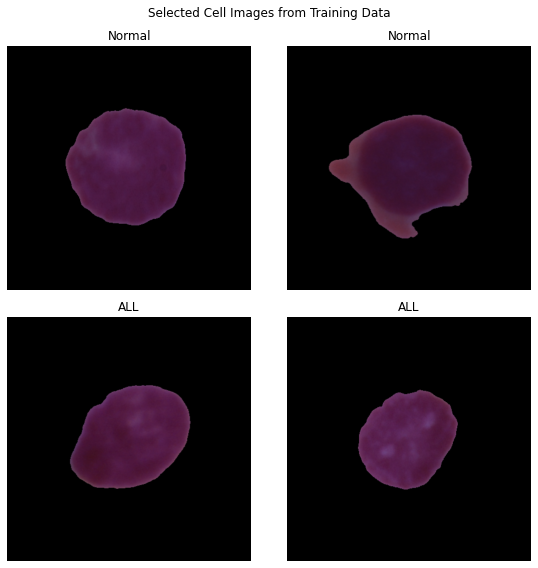

In [ ]:
# Review randomly selected images and plot with appropriate labels


normal_image_1 = cv2.imread(df['filepath'][8])
normal_image_2 = cv2.imread(df['filepath'][99])
all_image_1 = cv2.imread(df['filepath'][2011])
all_image_2 = cv2.imread(df['filepath'][5000])

fig = plt.figure(figsize = (8,8))

fig.add_subplot(2,2,1)
plt.imshow(normal_image_1)
plt.axis('off')
plt.title('Normal')

fig.add_subplot(2,2,2)
plt.imshow(normal_image_2)
plt.axis('off')
plt.title('Normal')

fig.add_subplot(2,2,3)
plt.imshow(all_image_1)
plt.axis('off')
plt.title('ALL')

fig.add_subplot(2,2,4)
plt.imshow(all_image_2)
plt.axis('off')
plt.title('ALL')

plt.suptitle('Selected Cell Images from Training Data')
plt.tight_layout()
plt.show()


# Plot several random images from each label group

Next, we look at our DataFrame of images and labels.  We know from creating the DataFrame above, that the information on the images and patients is sparse.  We do not have demographic information such as age, gender, any symptoms, other test results, etc. that could serve as predictors to enhance our model.  The images themselves and their labels are the only data available to make a prediction.  When we created the DataFrame, we noted that there were 10,661 rows and 2 columns (image path and label).  Below we look at the distribution of labels within the data.

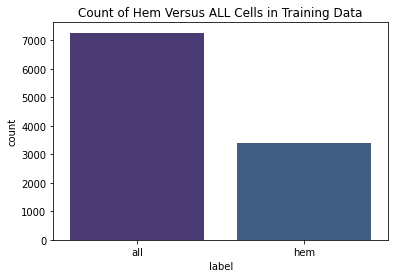

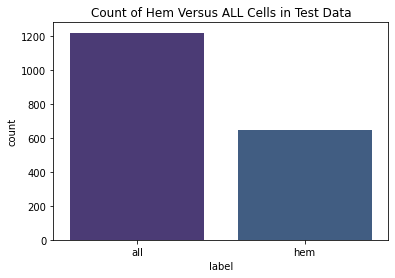

The distribution of cells labeled as 'hem' and 'ALL' within the training data is the following:
all    7272
hem    3389
Name: label, dtype: int64

The distribution of cells labeled as 'hem' and 'ALL' within the validation data is the following:
all    1219
hem     648
Name: label, dtype: int64

Hem to ALL ratio in the training data: 0.47
Hem to ALL ratio in the test data: 0.53


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of the bars
order = ["all", "hem"]

# We utilize a countplot from Seaborn to visualize how many samples we have of each label type
sns.set_palette('viridis')
sns.countplot(data=df, x='label', order=order).set_title("Count of Hem Versus ALL Cells in Training Data")
plt.show()

# To view comparable distribution in Test Set
sns.set_palette('viridis')
sns.countplot(data=df_test, x='label', order=order).set_title("Count of Hem Versus ALL Cells in Test Data")
plt.show()

print("The distribution of cells labeled as 'hem' and 'ALL' within the training data is the following:")
counts_train = df['label'].value_counts()
print(counts_train)

print("\nThe distribution of cells labeled as 'hem' and 'ALL' within the validation data is the following:")
counts_test = df_test['label'].value_counts()
print(counts_test)

hem_to_all_ratio_train = counts_train['hem'] / counts_train['all']
hem_to_all_ratio_val = counts_test['hem'] / counts_test['all']

print("\nHem to ALL ratio in the training data:", round(hem_to_all_ratio_train,2))
print("Hem to ALL ratio in the test data:", round(hem_to_all_ratio_val,2))

We can see from the plot above that the data is imbalanced and there are far more ALL cells than normal, or hem-labeled cells.  It appears to be roughly double the amount of diseased cells to normal cells.  We can consider data augmentation (using some sort of image manipulation on hem-labeled images) to increase the amount of normal cells our model is exposed to in order to balance the data.  First, let's quantify exactly how many we have of each label group.

We noticed significant blank space in our original images and sought to enhance our dataset quality, and improve our processing power, by cropping them. Cropping offers several benefits, including reducing data size, focusing on relevant features, improving performance, and enhancing model generalization. Our method involves multiple steps: reading images using OpenCV, converting them to grayscale, applying Otsu's thresholding to isolate foreground from background, extracting foreground regions, computing bounding boxes, and ultimately cropping the original images based on these boxes. Additionally, we've integrated optional resizing functionality to standardize cropped image dimensions. This systematic approach optimizes computational resource usage while retaining pertinent image details for subsequent analysis or modeling tasks.

In [ ]:
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Function to crop images using
def read_and_crop_image(image_path, resize=False, image_size=(224, 224)):
    # Read image
    image = cv2.imread(image_path)

    # Convert Color System from BGR(Blue, Green, Red) to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's Thresholding
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply threshold
    result = cv2.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))

    # Crop Image
    crop_img = image[mnx:mxx, mny:mxy, :]

    # Resize the image if specified
    if resize:
        resized_image = cv2.resize(crop_img, image_size)
    else:
        resized_image = crop_img

    return resized_image

After creating our function above to crop the images, we next apply the function in batches to both the training data and test datasets.  Cropping the images in batches allows us to efficiently process the images.

In [ ]:
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Define a directory to save cropped images for training set
cropped_training = 'cropped_images_training'
os.makedirs(cropped_training, exist_ok=True)

# Batch size
batch_size = 100

# Function to process a batch of images
def process_batch(df, output_dir):
    results = []
    for index, image_path in df:
        cropped_image = read_and_crop_image(image_path)
        if cropped_image is not None:
            output_path = os.path.join(output_dir, f'cropped_images_training_{index}.jpg')
            cv2.imwrite(output_path, cropped_image)
            results.append((index, output_path))
    return results

# Process training batches concurrently using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Prepare data for processing
    batches = [(i, row['filepath']) for i, row in df.iterrows()]
    # Split data into batches
    batched_data = [batches[i:i + batch_size] for i in range(0, len(batches), batch_size)]
    # Process batches concurrently
    training_results = executor.map(lambda batch: process_batch(batch, cropped_training), batched_data)

# Update DataFrame with cropped image file paths
for batch_results in training_results:
    for index, cropped_image_path in batch_results:
        df.at[index, 'cropped_filepath'] = cropped_image_path

print("Training images cropped successfully and DataFrame updated!")
executor.shutdown()

Training images cropped successfully and DataFrame updated!


In [ ]:
import cv2
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor

# Define a directory to save cropped images for validation set
cropped_test = 'cropped_images_test'
os.makedirs(cropped_test, exist_ok=True)

# Batch size
batch_size = 100

# Function to process a batch of images
def process_batch(batch, output_dir):
    results = []
    for index, image_path in batch:
        cropped_image = read_and_crop_image(image_path)
        if cropped_image is not None:
            output_path = os.path.join(output_dir, f'cropped_images_test_{index}.jpg')
            cv2.imwrite(output_path, cropped_image)
            results.append((index, output_path))
    return results

# Process validation batches concurrently using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Prepare data for processing
    batches = [(i, row['filepath']) for i, row in df_test.iterrows()]
    # Split data into batches
    batched_data = [batches[i:i + batch_size] for i in range(0, len(batches), batch_size)]
    # Process batches concurrently
    test_results = executor.map(lambda batch: process_batch(batch, cropped_test), batched_data)

# Update DataFrame with cropped image file paths
for batch_results in test_results:
    for index, cropped_image_path in batch_results:
        df_test.at[index, 'cropped_filepath'] = cropped_image_path

print("Test images cropped successfully and DataFrame updated!")
executor.shutdown()

Test images cropped successfully and DataFrame updated!


Below we randomly extract an image and compare the original image to the cropped image.

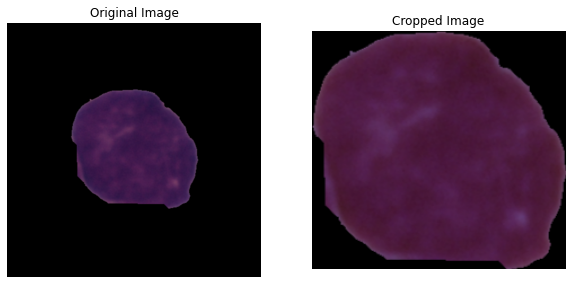

In [ ]:
# Side by side view of an original image v cropped image

import matplotlib.pyplot as plt

# Randomly select an image path from the DataFrame
random_image_path = np.random.choice(df['filepath'])

# Read the original image
original_image = cv2.imread(random_image_path)

# Display the original and cropped images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Read and crop the image
cropped_image = read_and_crop_image(random_image_path)

# Display cropped image
axes[1].imshow(cropped_image)
axes[1].set_title('Cropped Image')
axes[1].axis('off')

plt.show()

In [ ]:
# Check for null values in the cropped_filepath column (Training Set)
missing_values = df['cropped_filepath'].isnull().sum()

if missing_values == 0:
    print("All images were successfully cropped and added to the dataframe!")
else:
    print(f"There are {missing_values} images with missing cropped file paths. Please verify.")
    # Print rows with missing cropped file paths
    print("\nRows with missing cropped file paths:")
    print(df[df['cropped_filepath'].isnull()])

# Check in on Training df (optional)
print("Training Set:\n", df.head())

All images were successfully cropped and added to the dataframe!
Training Set:
                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
1  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
2  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
3  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
4  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                    cropped_filepath  
0  cropped_images_training/cropped_images_trainin...  
1  cropped_images_training/cropped_images_trainin...  
2  cropped_images_training/cropped_images_trainin...  
3  cropped_images_training/cropped_images_trainin...  
4  cropped_images_training/cropped_images_trainin...  


In [ ]:
# Check for null values in the cropped_filepath column (Validation Set)

missing_values = df_test['cropped_filepath'].isnull().sum()

if missing_values == 0:
    print("All images were successfully cropped and added to the dataframe!")
else:
    print(f"There are {missing_values} images with missing cropped file paths. Please verify.")
    # Print rows with missing cropped file paths
    print("\nRows with missing cropped file paths:")
    print(df_test[df_test['cropped_filepath'].isnull()])

# Check in on Validation df (optional)
print("\Test Set:\n", df_test.head())

All images were successfully cropped and added to the dataframe!
\Test Set:
                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/validation_d...   all   
1  extracted_contents/C-NMC_Leukemia/validation_d...   all   
2  extracted_contents/C-NMC_Leukemia/validation_d...   all   
3  extracted_contents/C-NMC_Leukemia/validation_d...   hem   
4  extracted_contents/C-NMC_Leukemia/validation_d...   all   

                                cropped_filepath  
0  cropped_images_test/cropped_images_test_0.jpg  
1  cropped_images_test/cropped_images_test_1.jpg  
2  cropped_images_test/cropped_images_test_2.jpg  
3  cropped_images_test/cropped_images_test_3.jpg  
4  cropped_images_test/cropped_images_test_4.jpg  


In [ ]:
import tensorflow as tf

# Function to preprocess images using TensorFlow
def preprocess_image(filepath, image_size=(244, 244)):
    try:
        # Read image
        image = tf.io.read_file(filepath)
        # Decode image
        image = tf.image.decode_jpeg(image, channels=3)
        # Resize image to desired dimensions
        image = tf.image.resize(image, image_size)
        # Normalize pixel values to [0, 1]
        image = tf.cast(image, tf.float32) / 255.0
        return image
    except Exception as e:
        print(f"Error processing image {filepath}: {e}")
        return None

# List to store preprocessed images
preprocessed_images = []

# Preprocess images in batches
batch_size = 100
num_images = len(df['cropped_filepath'])
num_batches = (num_images + batch_size - 1) // batch_size

print("Total number of images:", num_images)
print("Batch size:", batch_size)
print("Number of batches:", num_batches)

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_images)
    batch_filepaths = df['cropped_filepath'][start_idx:end_idx]

    batch_preprocessed_images = []
    print(f"Processing batch {i+1}/{num_batches}...")
    for idx, filepath in enumerate(batch_filepaths):
        preprocessed_image = preprocess_image(filepath)
        if preprocessed_image is not None:
            batch_preprocessed_images.append(preprocessed_image)
        print(f"Processed image {start_idx + idx + 1}/{num_images}", end="\r")

    # Convert list of preprocessed images to TensorFlow tensor
    batch_preprocessed_images = tf.convert_to_tensor(batch_preprocessed_images)
    preprocessed_images.append(batch_preprocessed_images)

print("\nAll images preprocessed successfully!")


Total number of images: 10661
Batch size: 100
Number of batches: 107
Processing batch 1/107...
Processing batch 2/107...
Processing batch 3/107...
Processing batch 4/107...
Processing batch 5/107...
Processing batch 6/107...
Processing batch 7/107...
Processing batch 8/107...
Processing batch 9/107...
Processing batch 10/107...
Processing batch 11/107...
Processing batch 12/107...
Processing batch 13/107...
Processing batch 14/107...
Processing batch 15/107...
Processing batch 16/107...
Processing batch 17/107...
Processing batch 18/107...
Processing batch 19/107...
Processing batch 20/107...
Processing batch 21/107...
Processing batch 22/107...
Processing batch 23/107...
Processing batch 24/107...
Processing batch 25/107...
Processing batch 26/107...
Processing batch 27/107...
Processing batch 28/107...
Processing batch 29/107...
Processing batch 30/107...
Processing batch 31/107...
Processing batch 32/107...
Processing batch 33/107...
Processing batch 34/107...
Processing batch 35/10

In [ ]:
# List to store preprocessed images for test set
preprocessed_images_test = []

# Preprocess images in batches for test set
num_images_test = len(df_test['cropped_filepath'])
num_batches_test = (num_images_test + batch_size - 1) // batch_size

print("Total number of images in test set:", num_images_test)
print("Batch size:", batch_size)
print("Number of batches:", num_batches_test)

for i in range(num_batches_test):
    start_idx_test = i * batch_size
    end_idx_test = min((i + 1) * batch_size, num_images_test)
    batch_filepaths_test = df_test['cropped_filepath'][start_idx_test:end_idx_test]

    batch_preprocessed_images_test = []
    print(f"Processing test batch {i+1}/{num_batches_test}...")
    for idx, filepath_test in enumerate(batch_filepaths_test):
        preprocessed_image_test = preprocess_image(filepath_test)
        if preprocessed_image_test is not None:
            batch_preprocessed_images_test.append(preprocessed_image_test)
        print(f"Processed test image {start_idx_test + idx + 1}/{num_images_test}", end="\r")

    # Convert list of preprocessed images to TensorFlow tensor
    batch_preprocessed_images_test = tf.convert_to_tensor(batch_preprocessed_images_test)
    preprocessed_images_test.append(batch_preprocessed_images_test)

print("\nAll test images preprocessed successfully!")


Total number of images in test set: 1867
Batch size: 100
Number of batches: 19
Processing test batch 1/19...
Processing test batch 2/19...
Processing test batch 3/19...
Processing test batch 4/19...
Processing test batch 5/19...
Processing test batch 6/19...
Processing test batch 7/19...
Processing test batch 8/19...
Processing test batch 9/19...
Processing test batch 10/19...
Processing test batch 11/19...
Processing test batch 12/19...
Processing test batch 13/19...
Processing test batch 14/19...
Processing test batch 15/19...
Processing test batch 16/19...
Processing test batch 17/19...
Processing test batch 18/19...
Processing test batch 19/19...
Processed test image 1867/1867
All test images preprocessed successfully!


In [ ]:
# Specify the paths where you want to save the CSV files
train_validate_file_path = 'train_validate.csv'
test_file_path = 'test.csv'

# Save the DataFrames as CSV files
df.to_csv(train_validate_file_path, index=False)  # Set index=False to avoid saving row numbers as a column
df_test.to_csv(test_file_path, index=False)  # Set index=False to avoid saving row numbers as a column

print(f"Train/validate DataFrame saved as CSV at: {train_validate_file_path}")
print(f"Test DataFrame saved as CSV at: {test_file_path}")

Train/validate DataFrame saved as CSV at: train_validate.csv
Test DataFrame saved as CSV at: test.csv


In [ ]:
# CAN START HERE TO TEST/RUN MODEL
import pandas as pd
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


df = pd.read_csv('train_validate.csv')
df_test = pd.read_csv('test.csv')

print("Train & Validate:", df.head())

print("\nTest:", df_test.head())

Train & Validate:                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
1  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
2  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
3  extracted_contents/C-NMC_Leukemia/training_dat...   hem   
4  extracted_contents/C-NMC_Leukemia/training_dat...   hem   

                                    cropped_filepath  
0  cropped_images_training/cropped_images_trainin...  
1  cropped_images_training/cropped_images_trainin...  
2  cropped_images_training/cropped_images_trainin...  
3  cropped_images_training/cropped_images_trainin...  
4  cropped_images_training/cropped_images_trainin...  

Test:                                             filepath label  \
0  extracted_contents/C-NMC_Leukemia/validation_d...   all   
1  extracted_contents/C-NMC_Leukemia/validation_d...   all   
2  extracted_contents/C-NMC_Leukemia/validation_d...   all   
3  extracted_contents/C-

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define model parameters
img_size = (224, 224, 3)  # Image size: 224x224 pixels with 3 channels (RGB)
num_classes = 2  # Number of classes: 2 for binary classification (Normal and Cancer)
batch_size = 32  # Define batch size

# Initial CNN Model
initial_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=img_size),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten layer to convert 2D feature maps to 1D feature vectors
    Dense(64, activation='relu'),  # Fully connected layer with ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the initial model
initial_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Display the initial model summary
initial_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into train and validate sets
train_validate, test = train_test_split(df, test_size=len(df_test), random_state=42)  # Using entire df_test for the test set
train, validate = train_test_split(train_validate, test_size=0.2, random_state=42)  # Adjust test_size as needed

# Display general stats
print("Train set:")
print("Shape:", train.shape)
print("Percentage of total data:", len(train) / len(df) * 100, "%")
print("Distribution of labels:")
print(train['label'].value_counts(normalize=True))
print("\n")

print("Validation set:")
print("Shape:", validate.shape)
print("Percentage of total data:", len(validate) / len(df) * 100, "%")
print("Distribution of labels:")
print(validate['label'].value_counts(normalize=True))
print("\n")

print("Test set:")
print("Shape:", test.shape)
print("Percentage of total data:", len(test) / len(df) * 100, "%")
print("Distribution of labels:")
print(test['label'].value_counts(normalize=True))
print("\n")

Train set:
Shape: (7035, 3)
Percentage of total data: 65.9881812212738 %
Distribution of labels:
all    0.686709
hem    0.313291
Name: label, dtype: float64


Validation set:
Shape: (1759, 3)
Percentage of total data: 16.499390301097456 %
Distribution of labels:
all    0.659466
hem    0.340534
Name: label, dtype: float64


Test set:
Shape: (1867, 3)
Percentage of total data: 17.51242847762874 %
Distribution of labels:
all    0.686127
hem    0.313873
Name: label, dtype: float64




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

# Define parameters
batch_size = 32
image_height = 224
image_width = 224

# Convert numerical labels to strings
train['label'] = train['label'].astype(str)
validate['label'] = validate['label'].astype(str)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255  # Rescale pixel values to the range [0, 1]
)

# Load cropped/preprocessed images for training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

# Load cropped/preprocessed images for validation set
validation_generator = datagen.flow_from_dataframe(
    dataframe=validate,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

# Load cropped/preprocessed images for test set
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col="cropped_filepath",
    y_col="label",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="binary",  # binary classification
)

# Train the model
history_initial = initial_model.fit(train_generator, epochs=20, validation_data=validation_generator)

Found 7035 validated image filenames belonging to 2 classes.
Found 1759 validated image filenames belonging to 2 classes.
Found 1867 validated image filenames belonging to 2 classes.
Epoch 1/20
220/220 [==============================] - 130s 591ms/step - loss: 0.3335 - accuracy: 0.8574 - val_loss: 0.4519 - val_accuracy: 0.8175
Epoch 2/20
220/220 [==============================] - 128s 582ms/step - loss: 0.2894 - accuracy: 0.8824 - val_loss: 0.4916 - val_accuracy: 0.8141
Epoch 3/20
220/220 [==============================] - 133s 605ms/step - loss: 0.2594 - accuracy: 0.8971 - val_loss: 0.4630 - val_accuracy: 0.8164
Epoch 4/20
220/220 [==============================] - 140s 635ms/step - loss: 0.2199 - accuracy: 0.9134 - val_loss: 0.4493 - val_accuracy: 0.8300
Epoch 5/20
220/220 [==============================] - 134s 610ms/step - loss: 0.1973 - accuracy: 0.9203 - val_loss: 0.5509 - val_accuracy: 0.8238
Epoch 6/20
220/220 [==============================] - 141s 639ms/step - loss: 0.1571 - 

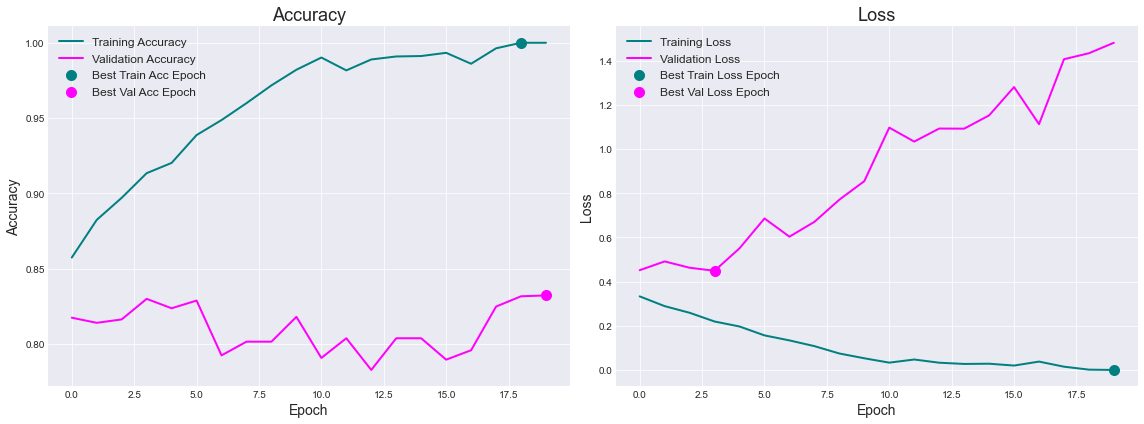

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the best epoch based on validation accuracy and validation loss
best_epoch_acc_train = np.argmax(history_initial.history['accuracy']) + 1
best_epoch_loss_train = np.argmin(history_initial.history['loss']) + 1
best_epoch_acc_val = np.argmax(history_initial.history['val_accuracy']) + 1
best_epoch_loss_val = np.argmin(history_initial.history['val_loss']) + 1

# Set the style
plt.style.use('seaborn-darkgrid')

# Create the plots
plt.figure(figsize=(16, 6))

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['accuracy'], color='teal', label='Training Accuracy', linewidth=2)
plt.plot(history_initial.history['val_accuracy'], color='magenta', label='Validation Accuracy', linewidth=2)
plt.scatter(best_epoch_acc_train - 1, history_initial.history['accuracy'][best_epoch_acc_train - 1], color='teal', label='Best Train Acc Epoch', zorder=5, s=100, marker='o')
plt.scatter(best_epoch_acc_val - 1, history_initial.history['val_accuracy'][best_epoch_acc_val - 1], color='magenta', label='Best Val Acc Epoch', zorder=5, s=100, marker='o')
plt.title('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_initial.history['loss'], color='teal', label='Training Loss', linewidth=2)
plt.plot(history_initial.history['val_loss'], color='magenta', label='Validation Loss', linewidth=2)
plt.scatter(best_epoch_loss_train - 1, history_initial.history['loss'][best_epoch_loss_train - 1], color='teal', label='Best Train Loss Epoch', zorder=5, s=100, marker='o')
plt.scatter(best_epoch_loss_val - 1, history_initial.history['val_loss'][best_epoch_loss_val - 1], color='magenta', label='Best Val Loss Epoch', zorder=5, s=100, marker='o')
plt.title('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# from tabulate import tabulate
# import re

# # Calculate the best epochs
# best_epoch_acc_train = np.argmax(history_initial.history['accuracy']) + 1
# best_epoch_loss_train = np.argmin(history_initial.history['loss']) + 1
# best_epoch_acc_val = np.argmax(history_initial.history['val_accuracy']) + 1
# best_epoch_loss_val = np.argmin(history_initial.history['val_loss']) + 1

# # Store accuracy and loss information
# accuracy_data = []
# loss_data = []

# # Append headers
# accuracy_data.append(["Epoch", "Training Accuracy", "Validation Accuracy", "Accuracy Delta"])
# loss_data.append(["Epoch", "Training Loss", "Validation Loss", "Loss Delta"])

# # Append accuracy information
# for epoch, (train_acc, val_acc) in enumerate(zip(history_initial.history['accuracy'], history_initial.history['val_accuracy']), start=1):
#     delta = abs(train_acc - val_acc)
#     row = [epoch, train_acc, val_acc, delta]
#     accuracy_data.append(row)

# # Append loss information
# for epoch, (train_loss, val_loss) in enumerate(zip(history_initial.history['loss'], history_initial.history['val_loss']), start=1):
#     delta = abs(train_loss - val_loss)
#     row = [epoch, train_loss, val_loss, delta]
#     loss_data.append(row)

# # Find the smallest delta and highlight those epochs in green
# min_delta_acc = min(accuracy_data[1:], key=lambda x: float(x[3]))[3]
# min_delta_loss = min(loss_data[1:], key=lambda x: float(x[3]))[3]

# # Print side-by-side tables
# print(tabulate(accuracy_data, headers="firstrow", tablefmt="grid"), end="\n\n")
# print(tabulate(loss_data, headers="firstrow", tablefmt="grid"))


+---------+---------------------+-----------------------+------------------+
|   Epoch |   Training Accuracy |   Validation Accuracy |   Accuracy Delta |
+=========+=====================+=======================+==================+
|       1 |            0.857427 |              0.81751  |        0.0399172 |
+---------+---------------------+-----------------------+------------------+
|       2 |            0.882445 |              0.814099 |        0.068346  |
+---------+---------------------+-----------------------+------------------+
|       3 |            0.897086 |              0.816373 |        0.0807131 |
+---------+---------------------+-----------------------+------------------+
|       4 |            0.913433 |              0.830017 |        0.0834158 |
+---------+---------------------+-----------------------+------------------+
|       5 |            0.920256 |              0.823763 |        0.0964924 |
+---------+---------------------+-----------------------+------------------+

The plots show the training and validation accuracy and loss over 20 epochs. Initially, both training and validation accuracy increase, while the loss decreases, indicating that the model is learning. However, there seems to be overfitting as the training accuracy continues to increase, while the validation accuracy stagnates or decreases, and the validation loss increases. We will need to adress overfitting concerns when improving our model.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = initial_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

59/59 [==============================] - 9s 153ms/step - loss: 3.8090 - accuracy: 0.6749
Test Loss: 3.8089964389801025
Test Accuracy: 0.6748794913291931


The substantial difference between the test, validation, and training sets indicates potential overfitting in the model. While the test set results serve as a good starting point, the significant gaps between these accuracies underscore the need for improvement. To address overfitting, strategies such as regularization techniques, data augmentation, and hyperparameter tuning should be implemented. By iteratively refining the model, we can enhance its generalization performance and ensure it performs well on unseen data, thus strengthening its reliability and applicability.

To enhance the model's performance, a series of iterative improvements were implemented. Initially, the model architecture was refined to incorporate convolutional layers for feature extraction, complemented by max-pooling layers to effectively condense spatial dimensions and capture prominent features. To address overfitting, dropout regularization was introduced, randomly deactivating neurons during training to promote better generalization.

Additionally, L2 regularization, also known as weight decay, was applied to the convolutional and dense layers. This regularization technique penalizes large weight values in the model, encouraging the learning of simpler patterns and reducing the risk of overfitting.

The Adam optimizer, equipped with a custom learning rate, was utilized to optimize model parameters efficiently, enhancing the model's learning capabilities. Furthermore, early stopping was integrated into the training process to halt training if the validation loss failed to improve, thereby mitigating overfitting and reducing training time.

Lastly, distributed training using TensorFlow's MirroredStrategy facilitated parallel processing across multiple GPUs, significantly accelerating the training process. These incremental enhancements collectively contributed to refining the model's performance and resilience, ensuring its effectiveness in real-world applications.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import itertools

In [ ]:
# Define Parameters and Hyperparameter ranges

# Define parameters
batch_size = 32
image_height = 224
image_width = 224
learning_rate = 0.001
l2_lambda = 0.001  # Regularization parameter for L2 regularization

# Define ranges for hyperparameters
epochs_range = [10, 20, 30]
learning_rate_range = [0.001, 0.01, 0.1]
dropout_rate_range = [0.2, 0.5]

In [ ]:
# Hyperparameter tuning - Grid Search

best_accuracy = 0
best_hyperparameters = {}

# Iterate over all combinations of hyperparameters
for epochs, learning_rate, dropout_rate in itertools.product(epochs_range, learning_rate_range, dropout_rate_range):

In [ ]:
# Build the model with L2 regularization & dropout

model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda), input_shape=(image_height, image_width, 3)),  # Convolutional layer with L2 regularization
    MaxPooling2D((2, 2)),  # Pooling layer
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),  # Convolutional layer with L2 regularization
    MaxPooling2D((2, 2)),  # Pooling layer
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_lambda)),  # Convolutional layer with L2 regularization
    MaxPooling2D((2, 2)),  # Pooling layer
    Flatten(),  # Flatten layer
    Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),  # Dense layer with L2 regularization
    Dropout(dropout_rate),  # Dropout layer with varying dropout rates
    Dense(1, activation='sigmoid')  # Output layer
    ])

In [ ]:
# Model compilation and training with early stopping

# Compile the model with a custom optimizer and learning rate
optimizer = Adam(learning_rate=learning_rate)  # Adam optimizer with custom learning rate
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])  # Monitor accuracy during training

# Define early stopping callback to prevent overfitting and reduce training time
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    verbose=0)  # Suppress verbose output

In [ ]:
# Evaluate the model on the validation set
accuracy = history.history['val_accuracy'][-1]

# Check if current hyperparameters yield better accuracy
if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_hyperparameters = {'epochs': epochs, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate}

print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_accuracy)

In [ ]:
# Evaluate the model on the test set (after improvements)
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss - After Improvements:", test_loss)
print("Test Accuracy - After Improvements:", test_accuracy)

In [ ]:
# Image Augmentation

# Take images with all label, rotate 90 degrees, add into dataframe
# Ideally making a 50/50 split of all/hem

# Look into converting to contrasting coloras

In [ ]:
# Test Set

# Make Predictions

# Display Predictions


We start our deep learning modeling with ResNet50, a commercially pre-trained model available in the Keras library.  It is a convolutional neural network, or CNN, created to help address the vanishing gradient problem in deep learning, allowing the model to be trained very deep.  ResNet was created by He, et al. in their [paper]("https://arxiv.org/pdf/1512.03385.pdf"), using the concept of residual learning.  Residual learning uses shortcut connections, which is what allows it to avoid vanishing gradients.  Below is a diagram from their paper showing how the connection provides a shortcut.


***IMAGE***


Below we import the baseline ResNet50 model, and then add additional layers on top to customize it for our data.  We use similar layers to the ones we later use when we build our own CNN.


In [ ]:
# Pre-Trained Model For Comparison

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model

resnet = ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape = (224,224,3))
    # include_top=False excludes the fully connected layer at the top of the network

# Customize ResNet50 for our data (to be placed on top of base resnet model above)
x = resnet.output
x = Flatten()(x)
    # Add an additional layer that will help the pre-trained model learn our data
x = Dense(512, activation='relu')(x)
    # Add a final layer with 2 neurons (for our two classes) that uses a softmax function
predictions = Dense(2, activation='softmax')(x)

resnet_model = Model(inputs=resnet.input, output=predictions)
resnet_model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])  # Monitor accuracy during training

resnet_model.summary()

# ML Models For Comparison?